# Генерация кода по вопросам со StackOverflow


In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import re

def tokenize_question(text):
    """
    Tokenizes question from a string into a list of strings (tokens) and reverses it
    """
    return list(filter(lambda x: len(x) < 16, re.findall(r"[\w']+", text)[::-1]))

def tokenize_snippet(text):
    """
    Tokenizes code snippet into a list of operands
    """
    return list(filter(lambda x: len(x) < 10, re.findall(r"[\w']+|[.,!?;:@~(){}\[\]+-/=\\\'\"\`]", text)))

In [4]:
import torch
from torchtext import data, datasets

SRC = data.Field(
    tokenize = tokenize_question, 
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
    include_lengths = True
)

TRG = data.Field(
    tokenize = tokenize_snippet, 
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True
)

fields = {
    'intent': ('src', SRC),
    'snippet': ('trg', TRG)
}

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
train_data, valid_data, test_data = data.TabularDataset.splits(
                            path = 'datasets/stackoverflow_code_generation/conala/',
                            train = 'conala-train.csv',
                            validation = 'conala-valid.csv',
                            test = 'conala-test.csv',
                            format = 'csv',
                            fields = fields
)

In [5]:
SRC.build_vocab([train_data.src], max_size=25000, min_freq=3)
print(SRC.vocab.freqs.most_common(20))


TRG.build_vocab([train_data.trg], min_freq=5)
print(TRG.vocab.freqs.most_common(20))

print(f"Уникальные токены в словаре интентов: {len(SRC.vocab)}")
print(f"Уникальные токены в словаре сниппетов: {len(TRG.vocab)}")

[('a', 1285), ('in', 949), ('python', 922), ('to', 851), ('how', 633), ('of', 602), ('list', 558), ('string', 397), ('the', 328), ('from', 275), ('with', 228), ('pandas', 192), ('i', 191), ('dictionary', 162), ('get', 151), ('convert', 134), ('values', 131), ('do', 125), ('dataframe', 111), ('into', 110)]
[(')', 3480), ('(', 3475), ('.', 2595), (',', 1899), ('[', 1122), (']', 1121), ('=', 927), ("'", 885), ('\\', 697), (':', 587), ('in', 504), ('x', 498), ('"', 496), ('for', 450), ('1', 377), ('-', 279), ('a', 265), ('0', 259), ('/', 257), ('df', 234)]
Уникальные токены в словаре интентов: 612
Уникальные токены в словаре сниппетов: 395


In [6]:
print(f"Размер обучающей выборки: {len(train_data.examples)}")
print(f"Размер валидационной выборки: {len(valid_data.examples)}")
print(f"Размер тестовой выборки: {len(test_data.examples)}")

Размер обучающей выборки: 2000
Размер валидационной выборки: 379
Размер тестовой выборки: 500


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

In [10]:
BATCH_SIZE = 2

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [24]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src sent len, batch size]
        #src_len = [src sent len]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu())
        
        packed_outputs, hidden = self.rnn(packed_embedded)
                     
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [12]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
                
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
            
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src sent len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
            trg = torch.zeros((100, src.shape[1])).long().fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        mask = self.create_mask(src)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            output, hidden, attention = self.decoder(output, hidden, encoder_outputs, mask)
            outputs[t] = output
            attentions[t] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)
            if inference and output.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions

In [25]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 100
DEC_HID_DIM = 100
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8
PAD_IDX = SRC.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
EOS_IDX = TRG.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

In [26]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(612, 128)
    (rnn): GRU(128, 100, bidirectional=True)
    (fc): Linear(in_features=200, out_features=100, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=300, out_features=100, bias=True)
    )
    (embedding): Embedding(395, 128)
    (rnn): GRU(328, 100)
    (out): Linear(in_features=428, out_features=395, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель содержит {count_parameters(model):,} параметров')

Модель содержит 615,651 параметров


Then we define our optimizer and criterion. We have already initialized `PAD_IDX` when initializing the model, so we don't need to do it again.

In [28]:
optimizer = optim.Adam(model.parameters())

In [29]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [30]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, attetion = model(src, src_len, trg, 0.4)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        print(f'{i+1}/{len(iterator)} batches, loss: {loss.item():.3f}')
        
    return epoch_loss / len(iterator)

In [31]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output, attention = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'conala_model_attention_test.pt')
    
    print(f'Эпоха: {epoch+1:02} | Время: {epoch_mins}m {epoch_secs}s')
    print(f'Перплексия (обучение): {math.exp(train_loss):7.3f}')
    print(f'Перплексия (валидация): {math.exp(valid_loss):7.3f}')

In [34]:
model.load_state_dict(torch.load('conala_model_attention_test.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Перплексия (валидация): {math.exp(test_loss):7.3f}')

Перплексия (валидация):  30.309


## Предсказание кода по вопросу

In [35]:
def translate_sentence(model, sentence):
    model.eval()
    tokenized = tokenize_question(sentence) 
    tokenized = ['<sos>'] + [t.lower() for t in tokenized] + ['<eos>']
    numericalized = [SRC.vocab.stoi[t] for t in tokenized] 
    sentence_length = torch.LongTensor([len(numericalized)]).to(device) 
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length, None, 0) 
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = [TRG.vocab.itos[t] for t in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    return translation, attention

In [36]:
def display_attention(candidate, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in tokenize_question(candidate)] + ['<eos>'], 
                       rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [37]:
example_idx = 2

src = ' '.join(vars(train_data.examples[example_idx])['src'])
trg = ' '.join(vars(train_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = object datetime to back string datetime a convert to how
trg = datetime . strptime ( '2010 - 11 - 13 10 : 33 : 54 . 227806' , ' y - m - d h : m : s . f' )


predicted trg =  re . datetime . <unk> ( ' )


C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_11256/3614225845.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in tokenize_question(candidate)] + ['<eos>'],
C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_11256/3614225845.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


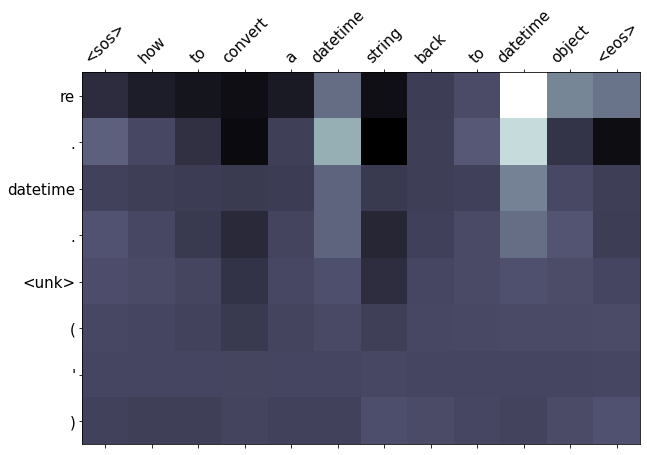

In [38]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ' '.join(translation))

display_attention(src, translation, attention)

In [39]:
example_idx = 8

src = ' '.join(vars(valid_data.examples[example_idx])['src'])
trg = ' '.join(vars(valid_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = string to tuple convert python
trg = " " " " " " . join ( ( 'a' , 'b' , 'c' , 'd' , 'g' , 'x' , 'r' , 'e' ) )


predicted trg =  print ( <unk> ( ) )


C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_11256/3614225845.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in tokenize_question(candidate)] + ['<eos>'],
C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_11256/3614225845.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


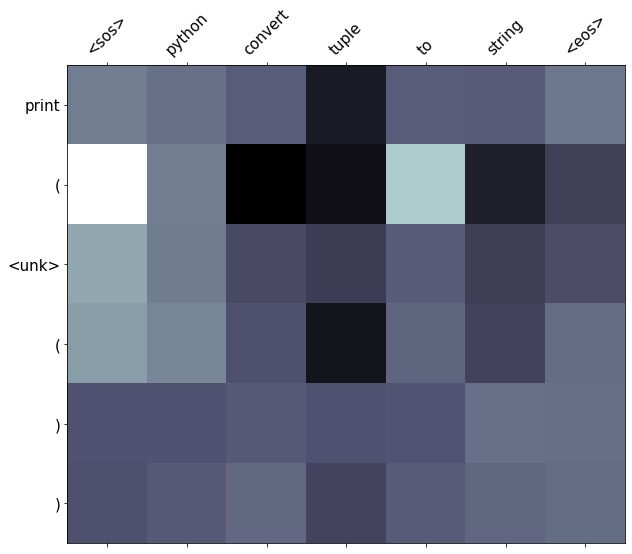

In [40]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ' '.join(translation))

display_attention(src, translation, attention)

In [41]:
example_idx = 4

src = ' '.join(vars(test_data.examples[example_idx])['src'])
trg = ' '.join(vars(test_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

src = 8 utf to 1251 cp from string a convert to how
trg = d . decode ( 'cp1251' ) . encode ( 'utf8' )


predicted trg =  print(<unk>.<unk>(<unk>)


C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_11256/3614225845.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in tokenize_question(candidate)] + ['<eos>'],
C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_11256/3614225845.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


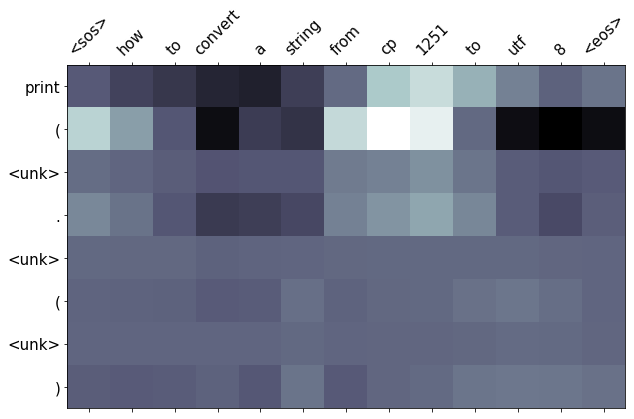

In [42]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ''.join(translation))

display_attention(src, translation, attention)